# **USECASE: Building a disease-disease similairty netwrok**

* DBRetina is an efficent tool for  building a similarity network for a set of items by pairwaise calcuation of their shared features using a linear-time algorithm.
* [DisGeNET](https://www.disgenet.org/) has one of the largest collections of genes associated to human diseases.
* In this tutorial, we will use DBRetina to build a disease-disease similairty netwrok based on the shared number of genes asscoiated with them in the DisGeNET database

In [1]:
%%bash
## Download the most recent version of disease gene associations from DisGeNET
if [ ! -f all_gene_disease_associations.tsv ];then
  wget -N http://www.disgenet.org/static/disgenet_ap1/files/downloads/all_gene_disease_associations.tsv.gz
  gunzip all_gene_disease_associations.tsv.gz
else echo "all_gene_disease_associations.tsv file exists in the disgenet DB";fi

--2021-05-21 20:49:37--  http://www.disgenet.org/static/disgenet_ap1/files/downloads/all_gene_disease_associations.tsv.gz
Resolving www.disgenet.org (www.disgenet.org)... 84.89.134.141
Connecting to www.disgenet.org (www.disgenet.org)|84.89.134.141|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.disgenet.org/static/disgenet_ap1/files/downloads/all_gene_disease_associations.tsv.gz [following]
--2021-05-21 20:49:40--  https://www.disgenet.org/static/disgenet_ap1/files/downloads/all_gene_disease_associations.tsv.gz
Connecting to www.disgenet.org (www.disgenet.org)|84.89.134.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21446175 (20M) [application/x-gzip]
Saving to: ‘all_gene_disease_associations.tsv.gz’

     0K .......... .......... .......... .......... ..........  0%  197K 1m46s
    50K .......... .......... .......... .......... ..........  0%  395K 79s
   100K .......... .......... .......... ......

In [2]:
%%bash
head -n3 all_gene_disease_associations.tsv

geneId	geneSymbol	DSI	DPI	diseaseId	diseaseName	diseaseType	diseaseClass	diseaseSemanticType	score	EI	YearInitial	YearFinal	NofPmids	NofSnps	source
        1	A1BG	0.7	0.538	C0001418	Adenocarcinoma	group	C04	Neoplastic Process	0.01	1	2008	2008	   1	   0	LHGDN
        1	A1BG	0.7	0.538	C0002736	Amyotrophic Lateral Sclerosis	disease	C18;C10	Disease or Syndrome	0.01	1	2008	2008	   1	   0	BEFREE


In [3]:
%%bash
## transform the data table into the DBRetina format
## DBRetina expects 2 files. Both are tab-separated files with two columns. Files must have header lines
## 1) Associations file: The 1st column for "items" and the 2nd for their asscoiated "features".
## 2) Super-association file: The 1st column for "items" and the 2nd for their "aliases". You can use this column to update the item name or if you want to pool multiple items together as one super item otherwise the 2nd column should be a copy of the 1st column
## In addition, we will filter the input list to keep trusted disease-gene associations only (DisGeNET score > 0.3)
cat all_gene_disease_associations.tsv | sed -e 's/^[ \t]*//' | awk 'BEGIN{FS=OFS="\t";}{if($10>0.3)print $6,$2}' > disgenet.asc
echo "item alias" | tr ' ' '\t' > disgenet.names
tail -n+2 disgenet.asc | awk 'BEGIN{FS=OFS="\t";}{print $1,$1}' | sort | uniq >> disgenet.names

In [4]:
%%bash
## Let us explore the format of the prepared filed
echo "DisGeNET input file"
wc -l all_gene_disease_associations.tsv
echo "==================="
echo "Associations file"
wc -l disgenet.asc
head -n3 disgenet.asc
echo "==================="
echo "Super-associations file"
wc -l disgenet.names
head -n3 disgenet.names

DisGeNET input file
1134943 all_gene_disease_associations.tsv
Associations file
33012 disgenet.asc
diseaseName	geneSymbol
Alzheimer's Disease	A2M
Malignant tumor of colon	A2M
Super-associations file
8156 disgenet.names
item	alias
11-Beta-hydroxylase deficiency	11-Beta-hydroxylase deficiency
12q14 microdeletion syndrome	12q14 microdeletion syndrome


In [5]:
%%bash
## Now we can run DBRetina
kPro_index="disgenetDBR"
DBRetina items_indexing -i disgenet.asc -n disgenet.names -p ${kPro_index}
DBRetina pairwise -i ${kPro_index}

# DBRetina has 3 output files:
# 1) The table of pairwise combinations "${kPro_index}_kSpider_pairwise.tsv": The items (i.e. diseases) are encoded as numerical IDs
# 2) The names map "${kPro_index}.namesMap": It maps each item to its ID
# 3) The nodes size "${kPro_index}_nodes_size.tsv": It reports the number of features associated with each item


In [6]:
%%bash
# Have a look on the output files
kPro_index="disgenetDBR"
echo "The table of pairwise combinations"
echo "----------------------------------"
head -n3 ${kPro_index}_kSpider_pairwise.tsv
echo "----------------------------------"
echo "The table of names map"
echo "----------------------"
head -n5 ${kPro_index}.namesMap
echo "----------------------"
echo "The table of nodes sizes"
echo "----------------------"
head -n3 ${kPro_index}_kSpider_seqToKmersNo.tsv
echo "----------------------"
# How many pairwise combinations did we do?
echo "The number of pairwise combinations =" $(wc -l ${kPro_index}_kSpider_pairwise.tsv | cut -d" " -f1)

The table of pairwise combinations
----------------------------------
ID	seq1	seq2	shared_kmers
1	7567	1086	1
2	4717	4624	3
----------------------------------
The table of names map
----------------------
8156
6507 Porphyrias, Hepatic
4100 INFLAMMATORY SKIN AND BOWEL DISEASE, NEONATAL, 1
1693 COMBINED OXIDATIVE PHOSPHORYLATION DEFICIENCY 15
5793 Neuronal Ceroid Lipofuscinosis Type 4B
----------------------
The table of nodes sizes
----------------------
ID	seq	kmers
1	6507	1
2	4100	1
----------------------
The number of pairwise combinations = 165824


In [7]:
%%bash
# Let us pool the output files into one final output 
# 1. merge the names map and nodes sizes in one output file
kPro_index="disgenetDBR"
paste <(tail -n+2 ${kPro_index}.namesMap |cut -d" " -f1)  <(tail -n+2 ${kPro_index}.namesMap |cut -d" " -f2-) > ${kPro_index}.namesMap.tmp
echo "node_id node_name size" | tr ' ' '\t' > ${kPro_index}_nodes_size.tsv
awk 'BEGIN{FS=OFS="\t";}FNR==NR{a[$2]=$3;next;}{if(a[$1]!="")print $0,a[$1]}' ${kPro_index}_kSpider_seqToKmersNo.tsv ${kPro_index}.namesMap.tmp >> ${kPro_index}_nodes_size.tsv
rm ${kPro_index}.namesMap.tmp*

# Let us have a look
head -n5 ${kPro_index}_nodes_size.tsv

node_id	node_name	size
6507	Porphyrias, Hepatic	1
4100	INFLAMMATORY SKIN AND BOWEL DISEASE, NEONATAL, 1	1
1693	COMBINED OXIDATIVE PHOSPHORYLATION DEFICIENCY 15	1
5793	Neuronal Ceroid Lipofuscinosis Type 4B	1


In [8]:
%%bash
# 2. Annotation of the numerically coded association file
# a) Add items names and no of associated items 
# b) calc jaccard distance and containment ratio for each pair
# c) Additionally, we can filter out those with minimal similarities 
kPro_index="disgenetDBR"
md=1   ## minimum jaccard distance (as a percentage) to keep the record 
mc=10  ## minimum containment ratio (as a percentage) to keep the record 
echo ":START_ID|START_name|START_size|shared_count:int|jDist:float|smPerc:float|END_name|END_size|:END_ID" > ${kPro_index}_relations.csv
awk -v md=$md -v mc=$mc 'BEGIN{FS="\t";S="|";}FNR==NR{a[$1]=$3;b[$1]=$2S$3;next;}{
   g1=a[$2]; g2=a[$3]; min=g1;min=(min < g2 ? min : g2); 
   jDist=$4*100/(g1+g2-$4); smPerc=$4*100/min; 
   if(jDist>md || smPerc>mc)
     printf("%s%s%s%s%s%s%.1f%s%.1f%s%s%s%s\n", $2,S,b[$2],S,$4,S,jDist,S,smPerc,S,b[$3],S,$3)}' \
   ${kPro_index}_nodes_size.tsv <(tail -n+2 ${kPro_index}_kSpider_pairwise.tsv) >> ${kPro_index}_relations.csv

# Let us have a look
wc -l ${kPro_index}_relations.csv 
echo "----------------------"
head -n5 ${kPro_index}_relations.csv

160985 disgenetDBR_relations.csv
----------------------
:START_ID|START_name|START_size|shared_count:int|jDist:float|smPerc:float|END_name|END_size|:END_ID
7567|Sturge-Weber Syndrome|2|1|50.0|100.0|CAPILLARY MALFORMATION-ARTERIOVENOUS MALFORMATION 1|1|1086
4717|Malignant neoplasm of gallbladder|8|3|7.3|37.5|Lymphoma|36|4624
4748|Mammary Neoplasms|329|2|0.6|40.0|Embryonal Rhabdomyosarcoma|5|2599
6151|Pancreatic Neoplasm|60|1|1.6|20.0|Collecting Duct Carcinoma of the Kidney|5|1657


In [9]:
%%bash
# Query for diseases with high similarity to any Alzheimer disease
kPro_index="disgenetDBR"
cat ${kPro_index}_relations.csv | grep -i "Alzheimer" | awk -F"|" '{if($5>10 && $6>25)print}' > ${kPro_index}_relations_Alzheimer.csv
# Check the impact of filtration
wc -l ${kPro_index}_relations.csv
echo "----------------------"
wc -l ${kPro_index}_relations_Alzheimer.csv
echo "----------------------"
# update the IDs to be from 1 to n where n is the number of diseases in this small file
tail -n+2 ${kPro_index}_relations_Alzheimer.csv | awk 'BEGIN{FS="|";OFS="\n";}{print $1"|"$2,$9"|"$7}' | sort -n | uniq |\
awk 'BEGIN{FS=OFS="|";}{print $1,NR,$2}' > id.map
wc -l id.map
echo "----------------------"
head -n5 id.map
echo "----------------------"
# Collect all pairwise distances of the diseases with high similarity to Alzheimer
head -n1 ${kPro_index}_relations.csv > ${kPro_index}_relations_newIds.csv
awk 'BEGIN{FS="|";OFS="|";}FNR==NR{a[$1]=$2;next;}{if(a[$1]&&a[$9]){$1=a[$1];$9=a[$9];print $0;}}' id.map ${kPro_index}_relations.csv >> ${kPro_index}_relations_newIds.csv
wc -l ${kPro_index}_relations_newIds.csv
echo "----------------------"
head -n5 ${kPro_index}_relations_newIds.csv

160985 disgenetDBR_relations.csv
----------------------
70 disgenetDBR_relations_Alzheimer.csv
----------------------
46 id.map
----------------------
90|1|ACNE INVERSA, FAMILIAL, 3
349|2|ALZHEIMER DISEASE 18
350|3|ALZHEIMER DISEASE 2
351|4|ALZHEIMER DISEASE 4
353|5|Alzheimer Disease, Early Onset
----------------------
521 disgenetDBR_relations_newIds.csv
----------------------
:START_ID|START_name|START_size|shared_count:int|jDist:float|smPerc:float|END_name|END_size|:END_ID
41|Presenile dementia|45|1|2.2|100.0|Multiple Sclerosis, Relapsing-Remitting|1|39
44|Sea-Blue Histiocyte Syndrome|1|1|2.2|100.0|Presenile dementia|45|41
28|Hepatolenticular Degeneration|11|3|15.0|27.3|Alzheimer Disease, Early Onset|12|5
37|Mental deterioration|6|1|4.8|16.7|Dementia|16|22


In [10]:
# enables the %%R magic
%load_ext rpy2.ipython

In [35]:
%%R 
if (!requireNamespace("RFLPtools", quietly = TRUE))
    install.packages("RFLPtools")
if (!requireNamespace("pheatmap", quietly = TRUE))
    install.packages("pheatmap")

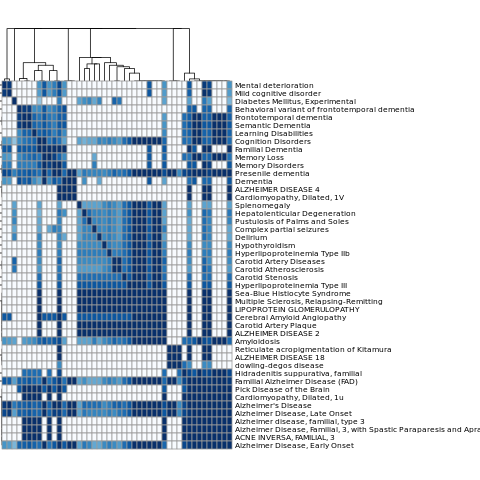

In [34]:
%%R 
kPro_index="disgenetDBR";
target="smPerc"

rels=paste(kPro_index,"relations_newIds.csv",sep="_");
dbretina_rel=read.table(file=rels ,skip=1, header=FALSE, sep = "|", quote = "", dec = "."); 
colnames(dbretina_rel)=c("START_ID","START_name","START_size","count","jDist","smPerc","END_name","END_size","END_ID")

dbretina_nodes=read.table(file="id.map", header=FALSE, sep = "|", quote = "");
size=dim(dbretina_nodes)[1]
dbret_count_matrix = matrix(0, nrow = size, ncol = size)
for (i in 1:dim(dbretina_rel)[1]){
  dbret_count_matrix[dbretina_rel$START_ID[i],dbretina_rel$END_ID[i]]=log2(dbretina_rel[[target]][i])
  dbret_count_matrix[dbretina_rel$END_ID[i],dbretina_rel$START_ID[i]]=log2(dbretina_rel[[target]][i])
}

## transform the similarity matrix into distance object (measure the dissimilarity)

library(RFLPtools)
dbret_count_dist = sim2dist(dbret_count_matrix, log2(100))
## Transform the dist object back into into matrix
dbret_count_matrix = as.matrix(dbret_count_dist)

rownames(dbret_count_matrix) <- dbretina_nodes$V3
colnames(dbret_count_matrix) <- NULL

library(pheatmap)
#library(repr)

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255) ## specify a blue color palette for painting
#options(repr.plot.width = 4, repr.plot.height = 2)
#jpeg("outfig")
pheatmap(dbret_count_matrix,
         clustering_distance_rows = dbret_count_dist,
         clustering_distance_cols = dbret_count_dist,
         col = colors, cellwidth=5,cellheight=8, fontsize_row=7.5,fontsize_col=0)
#dev.off()

In [14]:
%%bash
kPro_index="disgenetDBR"
#grep "ACNE" ${kPro_index}_nodes_size.tsv
cat ${kPro_index}_relations_newIds.csv

:START_ID|START_name|START_size|shared_count:int|jDist:float|smPerc:float|END_name|END_size|:END_ID
41|Presenile dementia|45|1|2.2|100.0|Multiple Sclerosis, Relapsing-Remitting|1|39
44|Sea-Blue Histiocyte Syndrome|1|1|2.2|100.0|Presenile dementia|45|41
28|Hepatolenticular Degeneration|11|3|15.0|27.3|Alzheimer Disease, Early Onset|12|5
37|Mental deterioration|6|1|4.8|16.7|Dementia|16|22
14|Carotid Artery Diseases|5|2|18.2|40.0|Amyloidosis|8|10
44|Sea-Blue Histiocyte Syndrome|1|1|6.2|100.0|Cognition Disorders|16|19
29|Hidradenitis suppurativa, familial|3|1|33.3|100.0|ACNE INVERSA, FAMILIAL, 3|1|1
39|Multiple Sclerosis, Relapsing-Remitting|1|1|1.1|100.0|Alzheimer's Disease|93|9
45|Semantic Dementia|6|1|16.7|100.0|Cardiomyopathy, Dilated, 1u|1|12
23|Diabetes Mellitus, Experimental|62|1|1.3|6.2|Cognition Disorders|16|19
32|Hypothyroidism|5|1|6.2|20.0|Alzheimer Disease, Early Onset|12|5
40|Pick Disease of the Brain|2|1|5.9|50.0|Dementia|16|22
44|Sea-Blue Histiocyte Syndrome|1|1|12.5|100.0|Am